In [1]:
import igl
import numpy as np
from scipy.io import savemat
import os
import sys


sys.path.append('../')
from utils.visual_utils import *
from utils.icp_utils import *

#from evaluation import *


In [2]:
import sys

sys.path.append(r'D:/Make_Galileo_great_again')
from utils.Morpho import *

sys.path.append('./pyFM/')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import itertools
import copy

import networkx as nx

import pyFM.spectral as spectral
from pyFM.mesh import TriMesh
from pyFM.FMN import FMN

from tqdm.auto import tqdm
import seaborn as sns


SamplesDir = r"../data/giorgio_"
maps_dict={}
N_meshes=4

m_list= []
m_rem_list= []
bm_list= []

#meshes in Trimesh
meshlist= []
rem_list_tri = []

#Dictionary where Fun Maps are stored.
maps_dict = {}

for i in range(N_meshes):
    
    PATH = os.path.join(SamplesDir, "remeshed", fr"0000{i:02d}_tumoredbrain.off")
    print(fr"0000{i:02d}_tumoredbrain/0000{i:02d}_tumoredbrain.off")
    PATH_hr = os.path.join(SamplesDir, fr"0000{i:02d}_tumoredbrain/0000{i:02d}_tumoredbrain.off")
    PATH_bm = os.path.join(SamplesDir, "bm", fr"bm{i:02d}.mat")

    if os.path.exists(PATH):

        rem_list_tri.append(TriMesh(PATH, area_normalize=True, center= True).process(k=110, intrinsic=True))
        meshlist.append(TriMesh(PATH_hr, area_normalize=True, center= True))
    #print("Mesh" , i, "loaded")

target_hr = TriMesh(r'../data/giorgio_/MNI.off', area_normalize=True, center= True)
meshlist.append(target_hr)
target_re = TriMesh(r'../data/giorgio_/MNI_remesh.off', area_normalize=True, center= True).process(k=110, intrinsic=True)
rem_list_tri.append(target_re)

#for i in range (N_meshes):
#    PATH_SAVE= os.path.join(SamplesDir, fr"FM\fmap12{i:02d}.npy")
#    FM_12_hks_zo=np.load(PATH_SAVE)
#    maps_dict[3,i]= FM_12_hks_zo.copy()
#    maps_dict[i,3]= FM_12_hks_zo.T



000000_tumoredbrain/000000_tumoredbrain.off
000001_tumoredbrain/000001_tumoredbrain.off
000002_tumoredbrain/000002_tumoredbrain.off
000003_tumoredbrain/000003_tumoredbrain.off


In [3]:
n_chosen_pairs = 200  # Number of pairs to select in the network
k_init = 20  # Initial size of functional maps. We recommand around 20 but because of the double surface we need 50
n_subsample = 3000 # Number of samples to use for initial maps

print(f'{int(scipy.special.binom(N_meshes, 2)):d} possible pairs')

6 possible pairs


In [4]:
rng = np.random.default_rng()

all_pairs = list(itertools.combinations(np.arange(N_meshes), 2))
rng.shuffle(all_pairs)

chosen_pairs = all_pairs[:n_chosen_pairs]

G = nx.Graph()
G.add_nodes_from(np.arange(N_meshes))
G.add_edges_from(chosen_pairs)


print(f'Is G connected ? {nx.is_connected(G)}')
all_cliques= nx.enumerate_all_cliques(G)
triad_cliques=[x for x in all_cliques if len(x)==3 ]
print(f'G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
print(f'G has {len(triad_cliques)} 3-cycles')

Is G connected ? True
G has 4 nodes and 6 edges
G has 4 3-cycles


In [5]:
subsample_list = np.zeros((N_meshes, n_subsample), dtype=int)
for i in tqdm(range(N_meshes)):
    print(i)
    subsample_list[i] = rem_list_tri[i].extract_fps(n_subsample, geodesic=False, verbose=False)
    

  0%|          | 0/4 [00:00<?, ?it/s]

0


1
2
3


In [6]:
maps_dict = {}

for pair_ind, (i, j) in enumerate(tqdm(chosen_pairs)):
    
    
    fps1 = subsample_list[i]
    fps2 = subsample_list[j]
    
       

    mesh1 = copy.deepcopy(rem_list_tri[i])
    mesh2 = copy.deepcopy(rem_list_tri[j])

    # Get initial correspondences
    p2p_21_init_sub = knn_query_normals(mesh1.vertlist[fps1], mesh2.vertlist[fps2],
                                                mesh1.vertex_normals[fps1], mesh2.vertex_normals[fps2],
                                                k_base=20, n_jobs=10, verbose=False)
    
    # ICP Align the shape
    _, R, t = icp_align(mesh2.vertlist[fps2], mesh1.vertlist[fps1],
                                p2p_12=p2p_21_init_sub,
                                return_params=True, n_jobs=10, epsilon=1e-4, verbose=False)

    mesh2.rotate(R)
    mesh2.translate(t)
    
    # Get final correspondences
    p2p_21 = knn_query_normals(mesh1.vertlist[fps1], mesh2.vertlist[fps2],
                                        mesh1.vertex_normals[fps1], mesh2.vertex_normals[fps2],
                                        k_base=20, n_jobs=10)
    
    p2p_12 = knn_query_normals(mesh2.vertlist[fps2], mesh1.vertlist[fps1],
                                        mesh2.vertex_normals[fps2], mesh1.vertex_normals[fps1],
                                        k_base=20, n_jobs=10)
        
    # Compute initial functional maps
    FM_12 = spectral.mesh_p2p_to_FM(p2p_21, rem_list_tri[i], rem_list_tri[j], dims=k_init, subsample=(fps1, fps2))
    FM_21 = spectral.mesh_p2p_to_FM(p2p_12, rem_list_tri[j], rem_list_tri[i], dims=k_init, subsample=(fps2, fps1))
    maps_dict[(i,j)] = FM_12.copy();
    maps_dict[(j,i)] = FM_21.copy();
    
print(f'{len(maps_dict.keys())} maps computed');


  0%|          | 0/6 [00:00<?, ?it/s]

12 maps computed


In [7]:
network = FMN(rem_list_tri[:N_meshes], maps_dict=maps_dict)

Setting 12 edges on 4 nodes.


In [8]:
czo_parameters = {
    'nit': (110-k_init)//5,
    'step': 5,
    'cclb_ratio': .8,
    'subsample': subsample_list,
    'isometric': False,
    'verbose': True,
    'weight_type': 'iscm',
    'n_jobs': 15,
}


network.zoomout_refine(**czo_parameters)


  0%|          | 0/17 [00:00<?, ?it/s]

In [9]:
network.compute_W(M=105)
network.compute_CCLB(int(.8*network.M), verbose=True)

Computing 105 CLB eigenvectors...
	Done in 0.1s


In [10]:
network.cclb_eigenvalues[:,None][0]=0

In [11]:
deviation_from_id_a = np.zeros(network.n_meshes)
deviation_from_id_cr = np.zeros(network.n_meshes)
for i in range(network.n_meshes):
    CSD_a, CSD_c = network.get_CSD(i)
    deviation_from_id_a[i] = np.linalg.norm(CSD_a - np.eye(CSD_a.shape[0]))
    deviation_from_id_cr[i] = np.linalg.norm(np.sqrt(network.cclb_eigenvalues[:,None]) * (CSD_c - np.eye(CSD_c.shape[0]))) / np.sqrt(network.cclb_eigenvalues.sum())

    
deviation_from_id_cr.argmin(), deviation_from_id_cr.argmin()


(3, 3)

In [12]:
base_meshind = deviation_from_id_cr.argmin()

In [13]:
k_displacement = 100
backend = 'gpu' # OR "cpu
from pyFM.FMN import FMN

In [14]:
import pyFM
mesh1 = copy.deepcopy(network.meshlist[base_meshind]) # TriMesh(network.meshlist[base_meshind].path, area_normalize=True).process(k=k_displacement,verbose=True)
LB_1 = network.get_LB(base_meshind, complete=True)  # (n_1',m)

displacements = np.zeros((network.n_meshes, 3*mesh1.n_vertices))
displacements_red = np.zeros((network.n_meshes, 3*k_displacement))

for meshind2 in tqdm(range(network.n_meshes)):
    if meshind2 == base_meshind:
        continue
    
    mesh2 = copy.deepcopy(network.meshlist[meshind2])
    LB_2 = network.get_LB(meshind2, complete=True)  # (n_2',m)
    
    #p2p_czo_12 = knn_query(torch.from_numpy(LB_2.astype(np.float32)).cuda(), torch.from_numpy(LB_1.astype(np.float32)).cuda(), backend=backend).cpu().numpy()

    p2p_czo_12 = knn_query(LB_2.astype(np.float32), LB_1.astype(np.float32))

    R, t = rigid_alignment(mesh1.vertlist, mesh2.vertlist, p2p_12=p2p_czo_12,
                                 return_params=True, return_deformed=False, weights=mesh1.vertex_areas)
    
    
    mesh2 = TriMesh(mesh2.vertlist, mesh2.facelist)
    mesh2.translate(-t)
    mesh2.rotate(np.linalg.inv(R))
    
    tau_czo = mesh1.project(mesh2.vertlist[p2p_czo_12] - mesh1.vertlist, k=k_displacement)
    
    displacements[meshind2] = mesh1.decode(tau_czo).flatten()
    displacements_red[meshind2] = tau_czo.flatten()
print('');

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

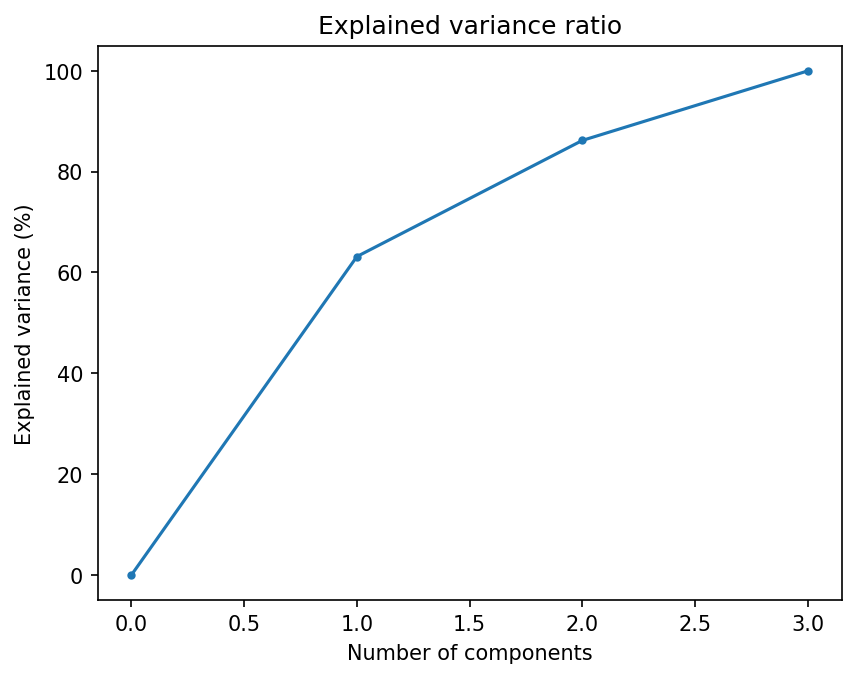

In [16]:
avg_disp = np.mean(displacements,axis=0)
pca_d = PCA(n_components=3)
emb_d_red = pca_d.fit_transform(displacements - avg_disp[None,:])

plt.figure(dpi=150)
plt.title('Explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.plot(np.arange(1+pca_d.n_components) , 100*np.cumsum(np.concatenate([[0],pca_d.explained_variance_ratio_])), marker=".");

In [17]:
labels = [1,2] # list of labels for each skulls
labels = np.asarray(labels)

In [18]:

reglin1 = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)

In [19]:
reglin1.fit(labels)

TypeError: LogisticRegression.fit() missing 1 required positional argument: 'y'

# SCALABLE


we have computed the CCLB ifor the low-resolution shapes. We want to project them in the high resolution space

In [20]:

bm_list=[]
for i in range(N_meshes):
    PATH_bm = os.path.join(SamplesDir, "bm", fr"bm{i:02d}.mat")
    if os.path.exists(PATH_bm):
        bm_list.append(scipy.io.loadmat(PATH_bm))

mesh1=meshlist[base_meshind]
mesh1.eigenvectors=bm_list[base_meshind]['U']@network.meshlist[base_meshind].eigenvectors

LB_1 = network.get_LB(base_meshind, complete=True)  # (n_1',m)
LB_1_hr=bm_list[base_meshind]['U']@LB_1


displacements_H = np.zeros((network.n_meshes, 3*mesh1.n_vertices))
displacements_red_H = np.zeros((network.n_meshes, 3*k_displacement))
displacements_H_xyz = np.zeros((network.n_meshes, 3*mesh1.n_vertices))

for meshind2 in tqdm(range(network.n_meshes)):
    if meshind2 == base_meshind:
        continue
    
    
    mesh2=meshlist[meshind2]
    LB_2 = network.get_LB(meshind2, complete=True)  # (n_1',m)
    LB_2_hr=bm_list[meshind2]['U']@LB_2

    #p2p_czo_12 = knn_query(torch.from_numpy(LB_2.astype(np.float32)).cuda(), torch.from_numpy(LB_1.astype(np.float32)).cuda(), backend=backend).cpu().numpy()

    p2p_czo_12 = knn_query(LB_2_hr.astype(np.float32), LB_1_hr.astype(np.float32))

    R, t = rigid_alignment(mesh1.vertlist, mesh2.vertlist, p2p_12=p2p_czo_12,
                                 return_params=True, return_deformed=False, weights=mesh1.vertex_areas)
    
    
    mesh2 = TriMesh(mesh2.vertlist, mesh2.facelist)
    mesh2.translate(-t)
    mesh2.rotate(np.linalg.inv(R))
    
    tau_czo_H = np.linalg.pinv(mesh1.eigenvectors[:,:k_displacement])@(mesh2.vertlist[p2p_czo_12] - mesh1.vertlist)
    
    displacements_H[meshind2] = (mesh1.eigenvectors[:,:k_displacement]@tau_czo_H).flatten()# mesh1.decode(tau_czo).flatten()
    displacements_red_H[meshind2] = tau_czo.flatten()
    displacements_H_xyz[meshind2] = (mesh2.vertlist[p2p_czo_12] - mesh1.vertlist).flatten()

print('')

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
#######################FILIPPOS###################à
bm_list=[]
for i in range(N_meshes):
    PATH_bm = os.path.join(SamplesDir, "bm", fr"bm{i:02d}.mat")
    if os.path.exists(PATH_bm):
        bm_list.append(scipy.io.loadmat(PATH_bm))

mesh1 = copy.deepcopy(network.meshlist[base_meshind]) # TriMesh(network.meshlist[base_meshind].path, area_normalize=True).process(k=k_displacement,verbose=True)
LB_1 = network.get_LB(base_meshind, complete=True)  # (n_1',m)

meshlist[base_meshind].eigenvectors=bm_list[base_meshind]['U']@network.meshlist[base_meshind].eigenvectors

displacements_H = np.zeros((network.n_meshes, 3*meshlist[base_meshind].n_vertices))
displacements_red_H = np.zeros((network.n_meshes, 3*k_displacement))
mesh1_eigenvectors_H=bm_list[base_meshind]['U']@network.meshlist[base_meshind].eigenvectors

k_fmap=105

for meshind2 in tqdm(range(network.n_meshes)):
    if meshind2 == base_meshind:
        continue
    print('init')
    
    mesh2 = copy.deepcopy(network.meshlist[meshind2]) # TriMesh(network.meshlist[base_meshind].path, area_normalize=True).process(k=k_displacement,verbose=True)
    LB_2 = network.get_LB(meshind2, complete=True)  # (n_1',m)

    #p2p_czo_12 = knn_query(torch.from_numpy(LB_2.astype(np.float32)).cuda(), torch.from_numpy(LB_1.astype(np.float32)).cuda(), backend=backend).cpu().numpy()

    p2p_czo_12 = knn_query(LB_2.astype(np.float32), LB_1.astype(np.float32))

    print('map')
    #BACK TO FMAP
    fmap=np.linalg.pinv(mesh1.eigenvectors[:,:k_fmap])@(mesh2.eigenvectors[p2p_czo_12,:k_fmap])
    print('p2p')

    p2p_czo_12_h = knn_query(bm_list[meshind2]['U']@mesh2.eigenvectors[:,:k_fmap], bm_list[base_meshind]['U']@mesh1.eigenvectors[:,:k_fmap]@fmap)

    R, t = rigid_alignment(meshlist[base_meshind].vertlist, meshlist[meshind2].vertlist, p2p_12=p2p_czo_12_h,
                                 return_params=True, return_deformed=False, weights=meshlist[base_meshind].vertex_areas)
    

    print('displ')

    mesh2 = TriMesh( meshlist[meshind2].vertlist,  meshlist[meshind2].facelist)
    mesh2.translate(-t)
    mesh2.rotate(np.linalg.inv(R))
    
    
    tau_czo_H = np.linalg.pinv(meshlist[base_meshind].eigenvectors[:,:k_displacement])@(meshlist[meshind2].vertlist[p2p_czo_12_h] - meshlist[base_meshind].vertlist)
    
    displacements_H[meshind2] =(meshlist[base_meshind].eigenvectors[:,:k_displacement]@tau_czo_H).flatten()# mesh1.decode(tau_czo).flatten()
    displacements_red_H[meshind2] = tau_czo.flatten()
    displacements_H_xyz[meshind2] = (meshlist[meshind2].vertlist[p2p_czo_12_h] - meshlist[base_meshind].vertlist).flatten()

print('')

  0%|          | 0/4 [00:00<?, ?it/s]

init
map
p2p


In [22]:
p2p_czo_12_h = knn_query(bm_list[meshind2]['U']@mesh2.eigenvectors[:,:k_fmap], bm_list[base_meshind]['U']@mesh1.eigenvectors[:,:k_fmap]@fmap)


KeyboardInterrupt: 

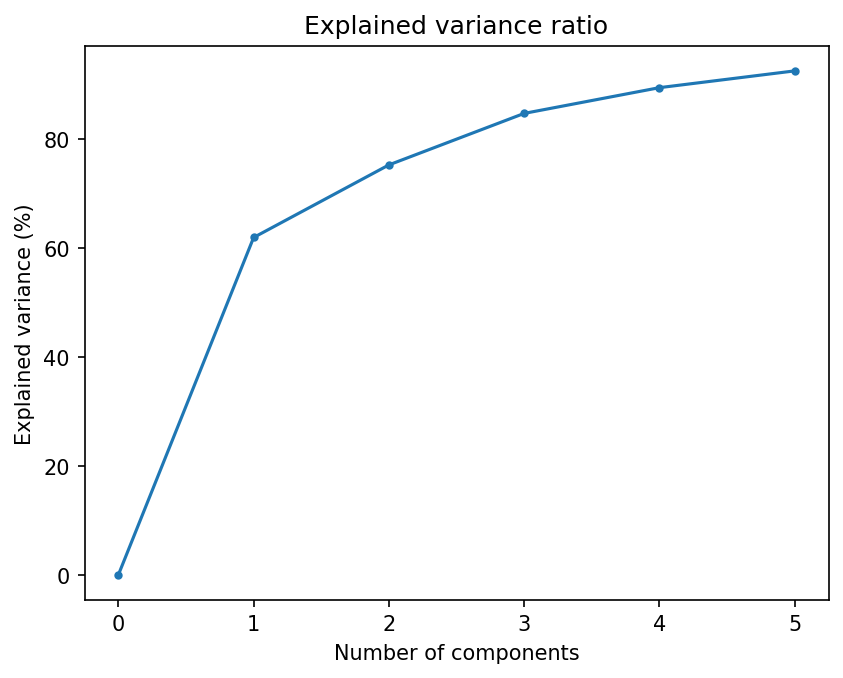

In [ ]:
avg_disp = np.mean(displacements,axis=0)
pca_d = PCA(n_components=5)
emb_d_red = pca_d.fit_transform(displacements - avg_disp[None,:])

plt.figure(dpi=150)
plt.title('Explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.plot(np.arange(1+pca_d.n_components) , 100*np.cumsum(np.concatenate([[0],pca_d.explained_variance_ratio_])), marker=".");